In [2]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_hierarchical, SEIR_hierarchical, plot_samples
import util

# Dev: Hierarchical Model

growth rate 0.26695555
growth rate [0.41301328 0.282086   0.42227292 0.31694555 0.30342096 0.19687617
 0.29438922 0.21223964 0.2090168  0.2343396 ]
beta0 [2.1691601 1.5220889 2.198268  1.5912652 1.4889927 0.9094019 1.4122155
 1.1194358 1.1943908 1.1305859]
sigma [0.22018673 0.1886625  0.20750247 0.19856569 0.20057422 0.22459158
 0.22902876 0.17204633 0.18611327 0.19945483]
gamma [0.34128284 0.3279236  0.30202666 0.2959813  0.28915128 0.28772557
 0.3235451  0.28893614 0.35356247 0.28549382]
det_rate [0.34266338 0.32712922 0.2873279  0.30463746 0.2903226  0.30631453
 0.33807647 0.27688327 0.3197083  0.28780875]


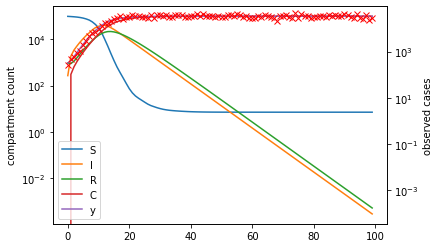

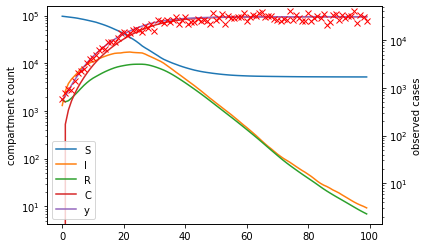

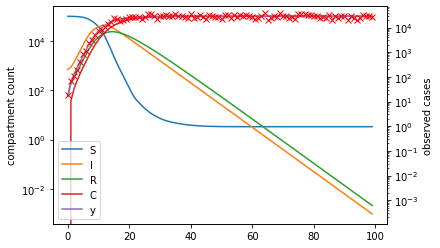

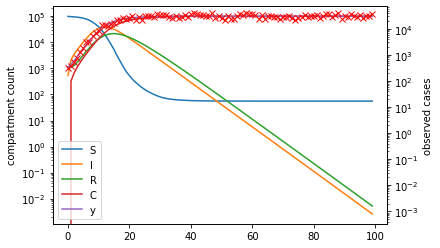

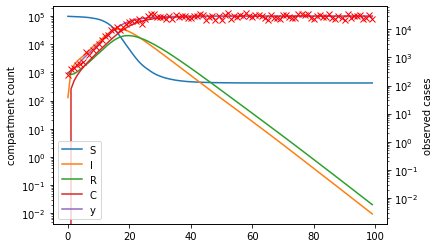

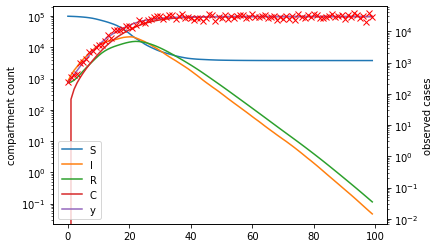

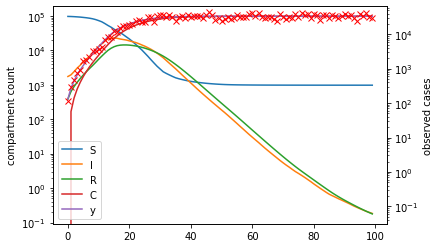

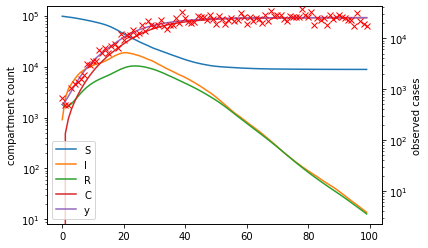

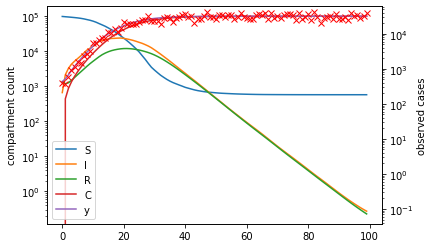

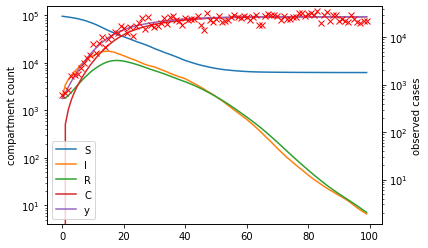

In [133]:
i = 1
num_places = 10
T = 50
T_future = 50
log_scale=True

with numpyro.handlers.seed(rng_seed=i):
    
    beta, xx, yy, oo = SEIR_hierarchical(num_places=num_places,
                                         T=T,
                                         T_future=T_future)

for x, y, obs_rate in zip(xx, yy, oo):

    T = x.shape[0]
    ts = np.arange(T)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    l1 = ax1.plot(ts, x)
    l2 = ax2.plot(ts, y, 'x', color='r')

    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])

    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )

    plt.show()

In [ ]:
#def test_prior_predictive():
T = 100
T_future = 100

num_places = 5

N = 10**np.arange(5)
predictive = Predictive(SIR_hierarchical, 
                        posterior_samples = {}, 
                        num_samples=1000)

samples = predictive(PRNGKey(2), 
                     num_places = num_places,
                     T = T, 
                     T_future=100,
                     N = N)

In [ ]:
from models import plot_samples

for i in range(num_places):

    shared_params = ['gamma_', 'beta_', 'det_rate_']
    place_samples = {k: v[:,i,...] for k, v in samples.items() if not k in shared_params}
    plot_samples(place_samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
# for i in range(2):
#     test_prior(i, num_places=3, T=50, T_future=50, N=1e8)
#test_prior_predictive()

# Run Inference

In [139]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

places = state_data.keys()
#places = ['NY', 'WA', 'MA', 'OH']
#places = ['NY', 'WA']

num_places = len(places)

start = pd.Timestamp('2020-03-04')

place_data = {place: data[place]['data'].confirmed for place in places}
confirmed = pd.DataFrame(data = place_data)[start:]

T = len(confirmed)
N = np.array([data[place]['pop'] for place in places])

args = {
    'num_places': num_places,
    'N': N,
    'T': T,
    'rw_scale': 2e-1,
    'det_conc': 10,
}

prob_model = SEIR_hierarchical

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=1000,
            num_samples=1000, 
            num_chains=1)

obs = confirmed.values.T

mcmc.run(jax.random.PRNGKey(1),
         obs = obs,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

# Prior samples for comparison
prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
prior_samples = prior(PRNGKey(2), **args)

# Posterior predictive samples for visualization
args['rw_scale'] = 0 # set drift to zero for forecasting
post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

growth rate 0.3055375
growth rate [0.28149897 0.3316328  0.22688472 0.31348792 0.3132144  0.33449405
 0.3272368  0.29103956 0.3535208  0.25470638 0.3070187  0.3356135
 0.29627353 0.31665275 0.2392863  0.30586198 0.27218637 0.3400253
 0.3138064  0.35341734 0.3192076  0.30122164 0.32132053 0.2976077
 0.28224638 0.31328613 0.32039312 0.3336102  0.23712748 0.32887733
 0.28201884 0.29727727 0.28906113 0.3249417  0.31416807 0.3922871
 0.29402986 0.3799615  0.33200005 0.27928314 0.2715729  0.28132856
 0.35537094 0.31269035 0.28072152 0.349307   0.33186933 0.30632794
 0.3132362  0.30424273 0.27218407]
beta0 [1.379804  1.5744809 1.099691  1.5416734 1.5361928 1.6602284 1.6240253
 1.3956935 1.7616699 1.25425   1.5360228 1.7338595 1.4282124 1.5049834
 1.1433235 1.4428496 1.3740168 1.6301198 1.5602598 1.8158906 1.6078889
 1.4644454 1.5824711 1.4708314 1.355753  1.6077739 1.5521624 1.6813072
 1.2127651 1.5507706 1.3766215 1.4119668 1.4329364 1.6305444 1.5762199
 1.9419897 1.4719309 1.8343116 1.59940

growth rate Traced<ConcreteArray(0.3055375)>with<JVPTrace(level=1/0)>
growth rate Traced<ConcreteArray([0.28149897 0.3316328  0.22688472 0.31348792 0.3132144  0.33449405
 0.3272368  0.29103956 0.3535208  0.25470638 0.3070187  0.3356135
 0.29627353 0.31665275 0.2392863  0.30586198 0.27218637 0.3400253
 0.3138064  0.35341734 0.3192076  0.30122164 0.32132053 0.2976077
 0.28224638 0.31328613 0.32039312 0.3336102  0.23712748 0.32887733
 0.28201884 0.29727727 0.28906113 0.3249417  0.31416807 0.3922871
 0.29402986 0.3799615  0.33200005 0.27928314 0.2715729  0.28132856
 0.35537094 0.31269035 0.28072152 0.349307   0.33186933 0.30632794
 0.3132362  0.30424273 0.27218407])>with<JVPTrace(level=1/0)>
beta0 Traced<ConcreteArray([1.379804  1.5744809 1.099691  1.5416734 1.5361928 1.6602284 1.6240253
 1.3956935 1.7616699 1.25425   1.5360228 1.7338595 1.4282124 1.5049834
 1.1433235 1.4428496 1.3740168 1.6301198 1.5602598 1.8158906 1.6078889
 1.4644454 1.5824711 1.4708314 1.355753  1.6077739 1.5521624 1.

  0%|          | 0/2000 [00:00<?, ?it/s]

growth rate 0.27988034
growth rate [0.14939678 0.09073702 0.23500594 0.39460352 0.50922453 0.26787227
 0.2356781  0.22540152 0.47311753 0.25220853 0.26134232 0.3570863
 0.3451264  0.29812375 0.54853225 0.39868143 0.11991298 0.1924394
 0.37374246 0.20202315 0.2663136  0.31698942 0.1303716  0.3296991
 0.2593336  0.09353355 0.22608721 0.25015578 0.32552242 0.4832182
 0.27254283 0.61002916 0.2603907  0.23932809 0.28299448 0.24898884
 0.2927414  0.19292685 0.30723396 0.29738563 0.23147303 0.21350925
 0.26811197 0.2321386  0.44191498 0.31524444 0.29132333 0.26567435
 0.17978317 0.28401023 0.32976604]
beta0 [0.8961529  0.63159597 1.3861488  2.234971   2.7582939  1.5462945
 1.1892257  1.0338678  2.506776   1.4187326  1.4443705  1.8936547
 1.6938776  1.4666054  3.0624332  2.1377103  0.724268   1.0482521
 1.7744029  1.0719525  1.3054756  1.3512949  0.6382497  1.7137073
 1.2102587  0.6647626  1.0730896  1.45186    1.6884674  2.651882
 1.4254091  3.6692133  1.2959714  1.0568026  1.470738   1.21297

sample: 100%|██████████| 2000/2000 [25:11<00:00,  1.32it/s, 75 steps of size 1.24e-02. acc. prob=0.84]  


growth rate Traced<ShapedArray(float32[]):JaxprTrace(level=0/0)>
growth rate Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>
beta0 Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>
sigma Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>
gamma Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>
det_rate Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>

                           mean       std    median      5.0%     95.0%     n_eff     r_hat
                E0[0]      3.29      1.62      3.18      1.17      6.20     44.63      1.01
                E0[1]     97.54     58.38     95.88      2.65    164.35     66.66      1.01
                E0[2]      2.91      1.83      2.54      0.06      5.54     55.35      1.01
                E0[3]      0.76      0.77      0.51      0.00      1.85     32.10      1.01
                E0[4]      0.45      0.36      0.35      0.00      0.94     42.38      1.01
                E0[5]      0.87      0.60      0.79      0.02      1

          beta[46,11]      1.55      0.32      1.52      1.07      2.06     67.36      1.01
          beta[46,12]      1.56      0.28      1.52      1.15      2.06     73.90      1.00
          beta[46,13]      1.57      0.28      1.52      1.12      2.04     76.97      1.02
          beta[46,14]      1.56      0.33      1.56      1.01      2.01     59.10      1.02
          beta[46,15]      1.57      0.40      1.50      0.95      2.12     34.02      1.00
          beta[46,16]      1.52      0.40      1.50      0.89      2.03     27.10      1.00
          beta[46,17]      1.39      0.28      1.39      0.97      1.82     37.87      1.03
          beta[46,18]      1.31      0.25      1.30      0.98      1.68     50.21      1.03
          beta[46,19]      1.26      0.25      1.23      0.89      1.59     70.45      1.02
          beta[46,20]      1.19      0.25      1.20      0.80      1.53     57.03      1.00
          beta[46,21]      1.14      0.22      1.15      0.77      1.45    107.3

growth rate Traced<ShapedArray(float32[]):JaxprTrace(level=0/0)>
growth rate Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>
beta0 Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>
sigma Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>
gamma Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>
det_rate Traced<ShapedArray(float32[51]):JaxprTrace(level=0/0)>


In [ ]:
from compartment import SEIRModel

gamma = mcmc_samples['gamma'].mean(axis=0)
beta0 = mcmc_samples['beta0'].mean(axis=0)
sigma = mcmc_samples['sigma'].mean(axis=0)

print("gamma", gamma)
print("beta", beta0)
print("sigma", sigma)
print("det_rate", mcmc_samples['det_rate'].mean(axis=0))

print("growth rate", SEIRModel.growth_rate((beta0, sigma, gamma)))

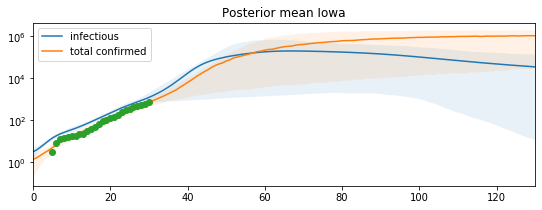

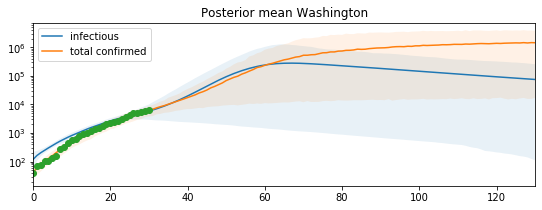

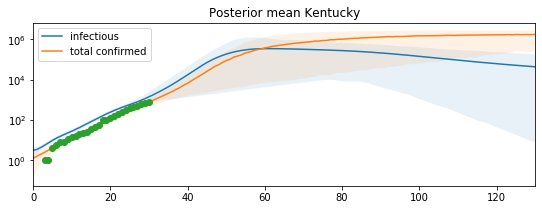

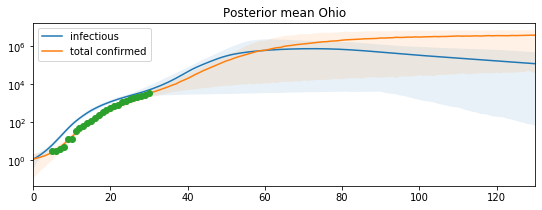

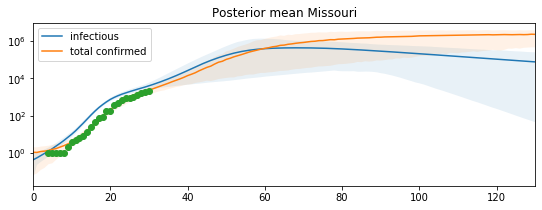

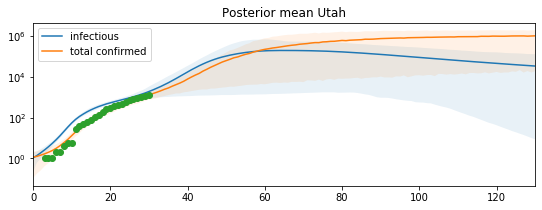

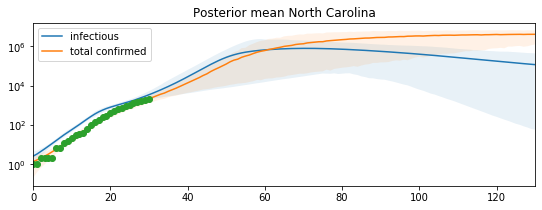

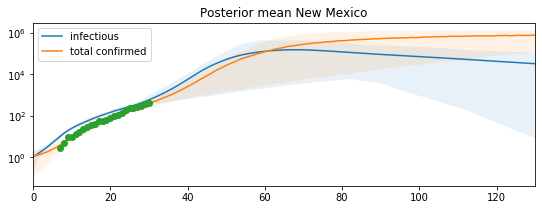

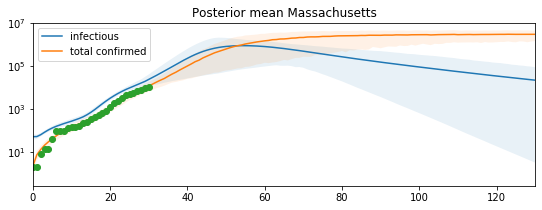

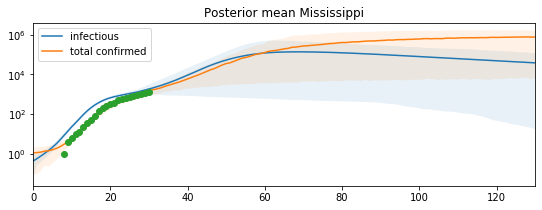

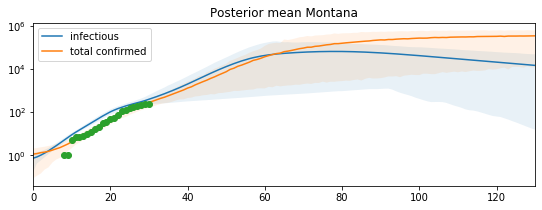

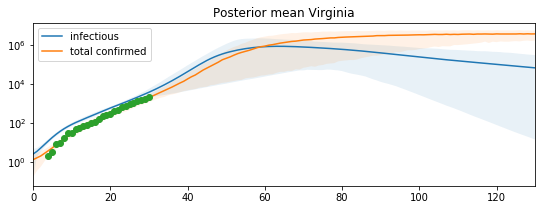

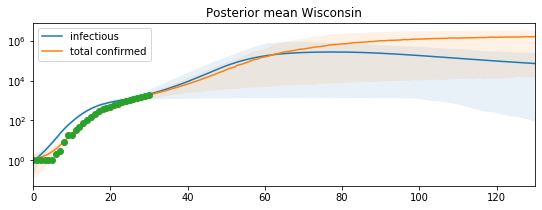

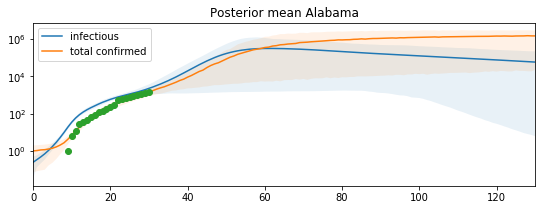

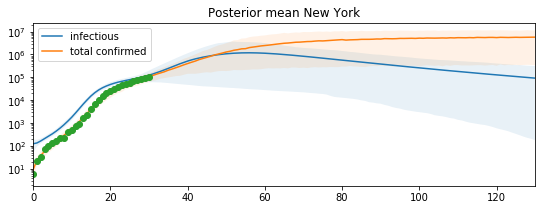

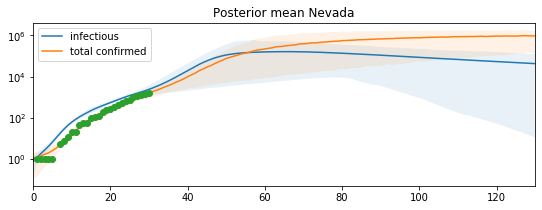

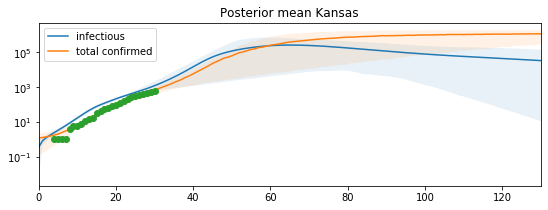

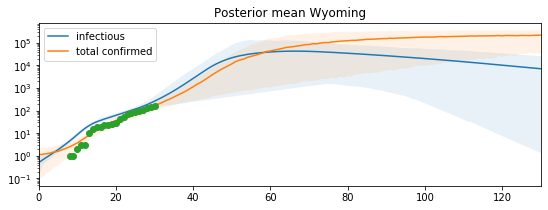

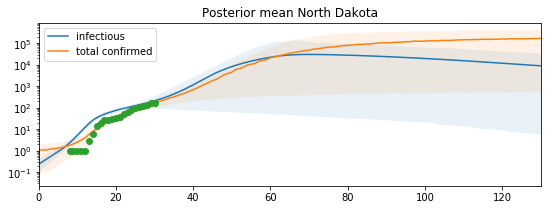

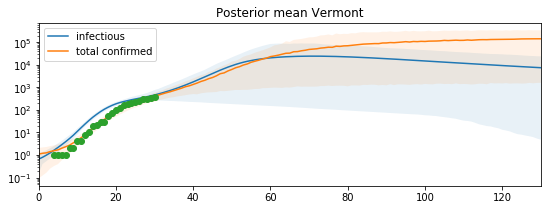

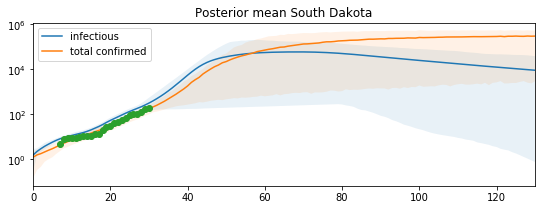

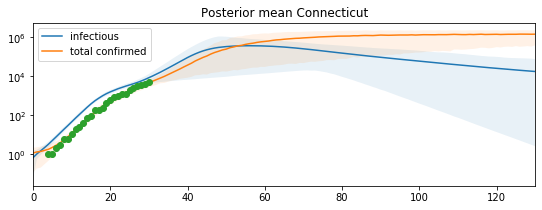

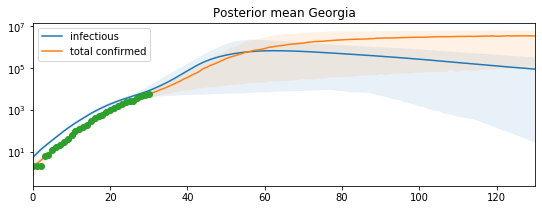

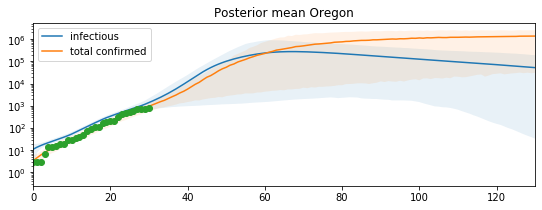

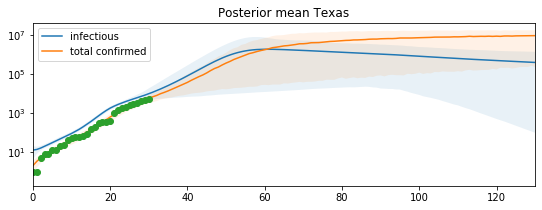

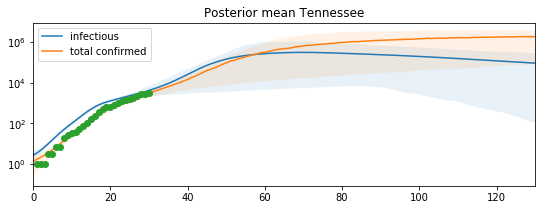

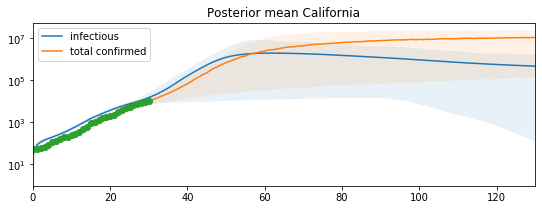

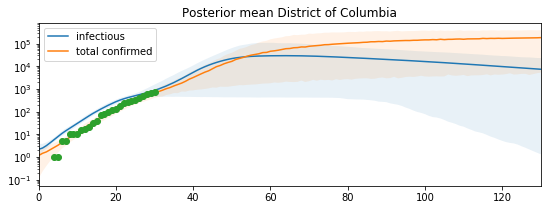

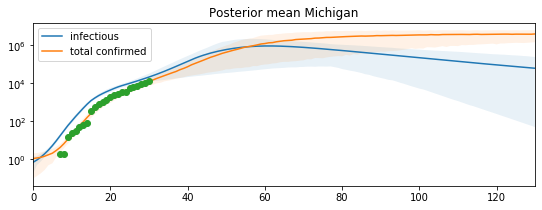

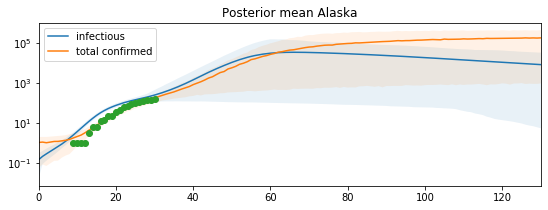

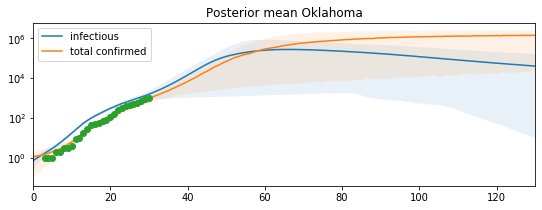

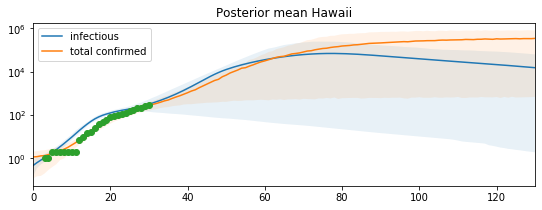

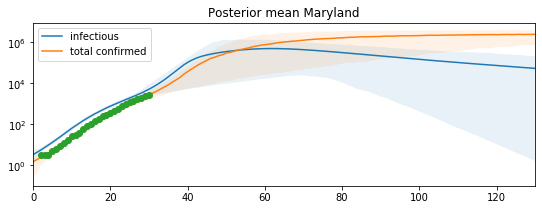

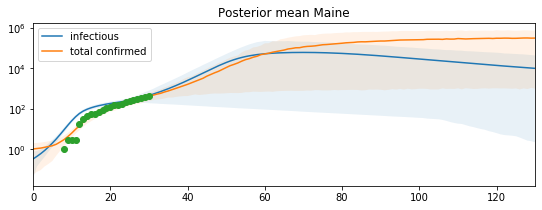

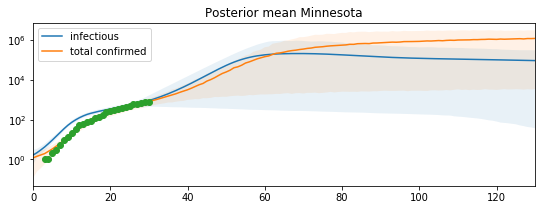

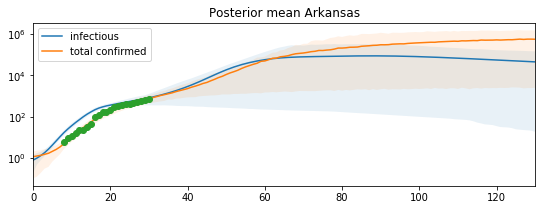

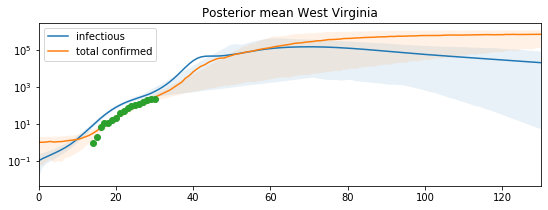

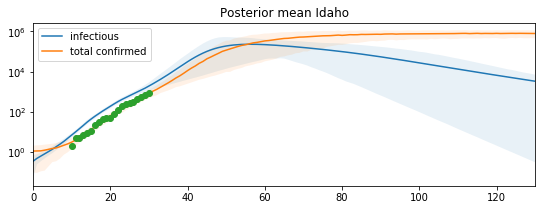

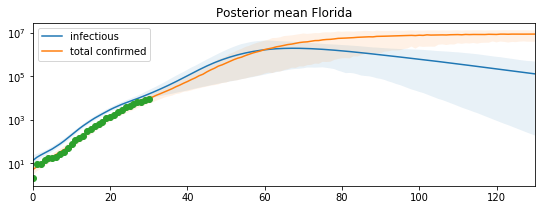

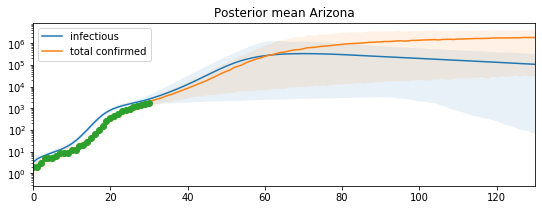

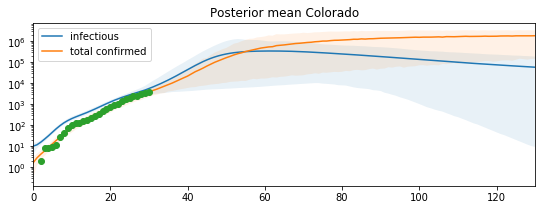

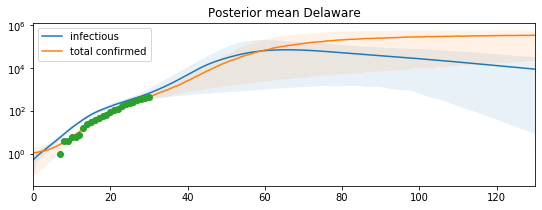

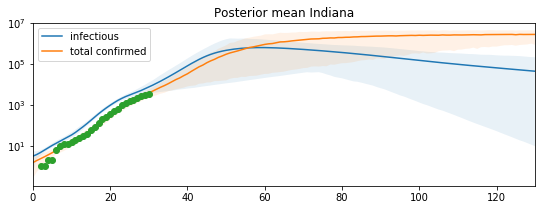

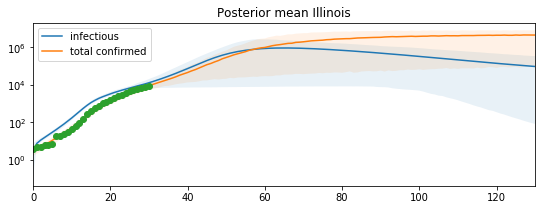

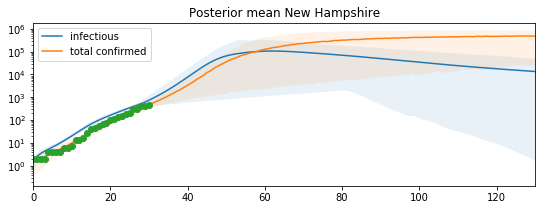

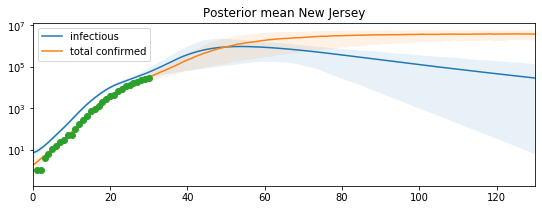

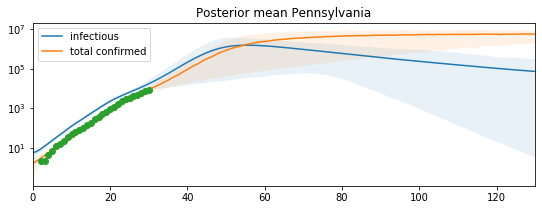

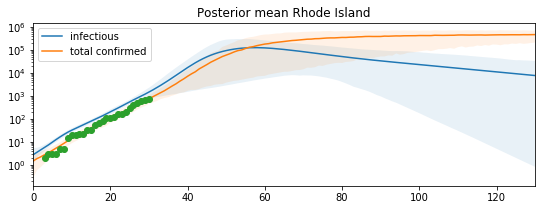

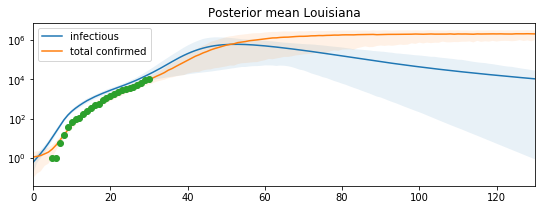

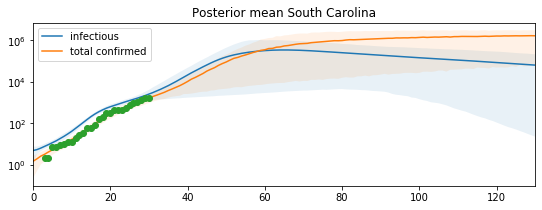

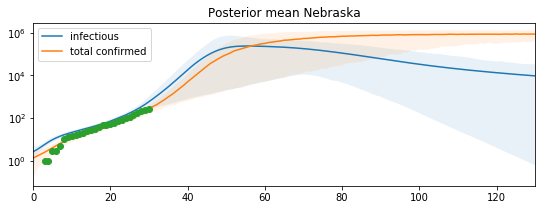

In [137]:
T = 150
for i, place in zip(range(num_places), places):
    
    fig, ax = plt.subplots(figsize=(9,3))
    shared_params = ['beta0_base', 'gamma_base', 'sigma_base', 'det_rate_base']
    place_samples = {k: v[:,i,...] for k, v in post_pred_samples.items() if not k in shared_params}
    plot_samples(place_samples, plot_fields=['I', 'y'], ax=ax, T=T)
    plt.plot(obs[i,:], 'o')
    
    name = data[place]['name']
    plt.title(f'Posterior mean {name}')
    plt.yscale('log')
    plt.show()


In [ ]:
load = True

for place in ['Italy', 'US', 'WA', 'NY', 'MA']:

    if load:
        confirmed = data[place].confirmed[start:]
        start = confirmed.index.min()

        T = len(confirmed)
        N = pop[place]

        filename = f'out/{place}_samples.npz'
        x = np.load(filename, allow_pickle=True)
        mcmc_samples = x['arr_0'].item()
        post_pred_samples = x['arr_1'].item()
        
    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
#print('init_params:  ', init_params)
print('constrain_fn: ', constrain_fn(init_params))
#print('potential_fn: ', potential_fn(init_params))
#print('grad:         ', jax.grad(potential_fn)(init_params))

pe, param_grads = value_and_grad(potential_fn)(init_params)
z_grad = ravel_pytree(param_grads)[0]


#print(jax.grad(potential_fn)(init_params))

In [ ]:
# Initialization test
prob_model = SEIR_hierarchical

rng_key = jax.random.PRNGKey(2)
init_params, potential_fn, constrain_fn = \
    numpyro.infer.util.initialize_model(rng_key, 
                                        prob_model,
#                                        init_strategy = numpyro.infer.util.init_to_feasible(),
#                                        init_strategy = numpyro.infer.util.init_to_uniform(),
                                        init_strategy = numpyro.infer.util.init_to_median(),
#                                        init_strategy = numpyro.infer.util.init_to_prior(),
                                        model_kwargs = args)

In [ ]:
plt.figure(figsize=(20,20))
top_20 = world.loc[:,(slice(None), 'tot', 'confirmed')].iloc[-1].sort_values(ascending=False)[:20]